# Project background

Automatic seismogram picking is an issue known from late 70s. During the years many different approaches to the problem have been proposed. First studies in this field given by Allen (1978) or Baer and Kradolfer (1987) was based on the comparison between the **short-(STA) and the long-term average (LTA)** of the signal. Another approaches to find seismic waves on digital records are using **autoregressive methods (AR)** (Leonard and Kennett, 1999; Leonard, 2000), **high order statistics (HOS)** (Küperkoch et al., 2010), **Continuous Wavelet Transform (CWT)** (Zhang et al., 2003) or algorithms that use **neural networks** (Wang and Teng, 1995). 

Auto-picking algoritms are already successfully implemented in ***early warning systems*** such as ShakeAlert® given by USGS or in local systems used for seismic hazard monitoring in the vicinity of vulcanos or regions, like Chile or Japan. Furthermore auto-picking tools can be also used to process of large seismic waveforms datasets. These methods enables e.g. basic analysis like **localization of seismic events** or **earthquake energy estimation**.

Nevertheless such algorithm are still rarely used to monitor and detect induced seismic events. Because of low energy and shallow seismic source locations, the detection of seismic waves in anthropogenic seismicity is a challenging task. This project is a first step in creation of auto-picking tool for in-mine underground monitoring system. I present an **auto-detection of mining induced earthquakes based on P-waves and high order statistics approach combine with convolutional neural networks (CNN).** The idea of this work was inspired by research of Gentili and Michelini (2006), Ross et al. (2018) and an on-line publication *"Introduction to 1D Convolutional Neural Networks in Keras for Time Sequences* publish on https://blog.goodaudience.com/.

# Data

Data used to train and test the project algorithm comes from **LUMINEOS Network** owned by Institute of Geophysics Polish Academy of Sciences. LUMINEOS Network is used to monitor the seismic activity induced by mining operations of **Rudna Copper Mine** located in area of **Legnica-Głogów Copper District (LGCD)**, SW Poland (see map below). The network registers ~ 2000 induced seismic events of magnitude M>1.5 annualy. LUMINEOS consist of seismometers (GeoSIG VE-53/BB, sampling rate: 100 Hz) and accelerometers (GeoSIG AC-63, sampling rate: 250 Hz) sensors. More informations about data and monitoring system can be fount in **IS-EPOS Research Platform** (https://tcs.ah-epos.eu/) under the LGCD episode. In this project, due to the hardware limitations, only the registrations in time domain (seismometers records) are used.  

Project dataset consist of **daily continous records in form of .mseed files** and **.txt files with P and S waveform picks** (marks of wave detection on digital seismograms) done mannualy in IGF PAS for localization and events energy estimation. Data used in the project were **registered between 08 March 2016 and 25 March 2016**. During this time **31 induced earthquakes** have been detected.


*Since algorithm will be used to seismic events detection basing on P-wave first arrivals, **dataset contains only vertical component** of seismograms.*

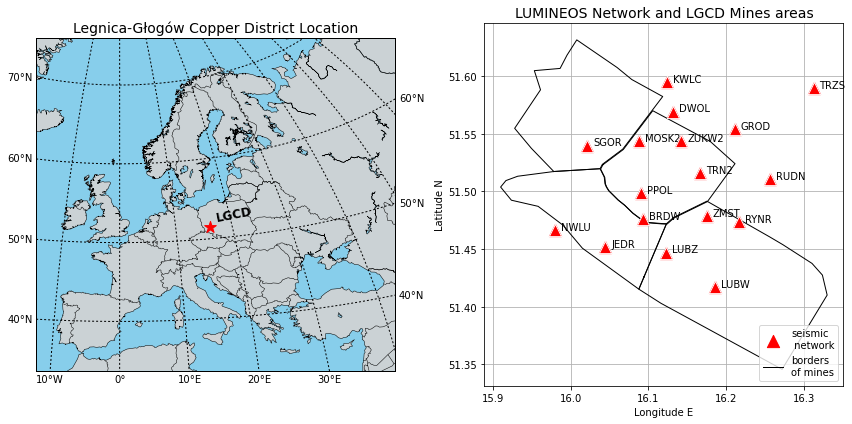

In [1]:
## -- MAP OF STUDY AREA AND THE LUMINEOS NETWORK -- ##

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Polygon
from mpl_toolkits.basemap import Basemap

fig1 = plt.figure(figsize=(12,6))

### LGCD location in Europe ###
ax1 = fig1.add_subplot(121)
m = Basemap(resolution='l',
            projection='aeqd',
            lat_0=0, lon_0=0,
            llcrnrlon=-12., llcrnrlat= 33.5, urcrnrlon=75., urcrnrlat=64.5)

m.drawmapboundary(fill_color='skyblue')
m.fillcontinents(color='lightgray', lake_color='skyblue', alpha=0.9)
m.drawcoastlines(linewidth=0.5)
m.drawcountries()
m.drawparallels(np.arange(10.,71.,10.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-10.,70.,10.),labels=[False,False,False,True],dashes=[2,2])

x, y = m([16.0675], [51.501111])
m.scatter(x, y, marker='*', color='r', s=150, zorder=10)
plt.annotate('LGCD', m(17.0675, 52.101111), rotation=11, fontsize=12, fontweight='bold')
plt.title("Legnica-Głogów Copper District Location", fontsize=14)


### LUMINEOS Network + Mines Borders ###
ax2 = fig1.add_subplot(122)
st = np.loadtxt('stations.table', usecols=(1, 2))
lu = np.loadtxt('Lubin.d', usecols=(0, 1))
po = np.loadtxt('Polkowice.d', usecols=(0, 1))
ru = np.loadtxt('Rudna.d', usecols=(0, 1))
si = np.loadtxt('Sieroszowice.d', usecols=(0, 1)) 

label = [x.split('\t')[0] for x in open('stations.table').readlines()][:-1]

X, Y = st[:,1], st[:,0]
Xlu, Ylu = lu[:,1], lu[:,0]
Xpo,Ypo = po[:,1], po[:,0]
Xru, Yru = ru[:,1], ru[:,0] 
Xsi, Ysi = si[:,1], si[:,0]

sns.scatterplot(x=X, y=Y, marker='^', color = 'r', s = 150, zorder=10, ax=ax2)

for x,y,l in zip(X,Y,label):
        ax2.annotate(l,
                    (x,y),
                    textcoords = 'offset points',
                    fontsize = 10,
                    xytext = (6,0),
                    ha = 'left')

rudna = plt.Line2D(Xru, Yru, lw=1.0, color='k')
lubin = plt.Line2D(Xlu, Ylu, lw = 1.0, color = 'k')
polko = plt.Line2D(Xpo, Ypo, lw = 1.0, color = 'k')
siero = plt.Line2D(Xsi, Ysi, lw = 1.0, color = 'k')
ax2.add_line(rudna)
ax2.add_line(lubin)
ax2.add_line(polko)
ax2.add_line(siero)

ax2.set_xlabel('Longitude E')
ax2.set_ylabel('Latitude N')

legend_elements = [plt.scatter(X,Y,marker='^', color = 'r', s = 150, label="seismic\n network"),
                    Line2D([0], [0], color = 'k',lw = 1.0, label='borders\nof mines')]
plt.legend(handles=legend_elements, loc='lower right')

plt.title("LUMINEOS Network and LGCD Mines areas", fontsize=14)

ax2.grid(True)
plt.tight_layout()

plt.show()

#### Packages used in the project

In [21]:
import numpy as np
import pandas as pd
import obspy as ob
from obspy.core import UTCDateTime

import pickle
import random
import os
import re

from scipy.stats import skew, kurtosis

from datetime import timedelta
from datetime import datetime as dtime

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D,\
                                    GlobalAveragePooling1D, \
                                    Dropout, Flatten, Dense, Reshape
from sklearn.metrics import classification_report, accuracy_score

# Data preprocessing

Due to hardware limitations, all data were prepared separately for one day packages according the scheme presented below. Sheme show data processing for dataset recorded at 8th of March 2016.

All data after preprocessing are stored in pickle (.pckl) files and can be used without re-processing.


### Dataset_08_03_2016:

#### -> Seismic wave markers
Data of P and S waves markers for each station are stored in form of daily datasets in .txt files together with additional data e.g.:
- natwork ID - Net, 
- station name - Sta, 
- channel ID - Chan, 
- date and time of earthquake - Date and Time,
- seismic wave marker - Phase,
- seismic event ID, 
- author of the elaboration

Data has to be filtered, arrival times has to be merge with seismic records.

In [3]:
## -- sample of seismic signal in form of one day record from GROD station: -- ##

work_dir = os.path.abspath('.')
data_dir = os.path.abspath('..')
data_8_dir = data_dir+'\\08_03_2016\\'
list_file = os.listdir(data_8_dir)[:-1]
list_file.sort()

picks = pd.read_csv(data_8_dir+list_file[-1], sep=" ", skiprows=5, 
                    skipinitialspace=True, header=None)
picks

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Net,Sta,Chan,Aux,Date,Time,Phase,Azim,Slow,SNR,Amp,Per,Qual,Group,C,Author,ArrID
1,PL,BRDW,EHZ,2016/03/08,00:19:57.515,Pg,m_e,19189,PL_idobrz,116764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PL,BRDW,EHN,2016/03/08,00:19:58.112,Sg,m_e,19189,PL_idobrz,116765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PL,DWOL,EHZ,2016/03/08,00:19:59.270,Pg,m_e,19189,PL_idobrz,116766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PL,DWOL,EHN,2016/03/08,00:20:01.196,Sg,m_e,19189,PL_idobrz,116767,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,PL,SGOR,EHZ,2016/03/08,22:26:20.545,Pg,m_e,18928,PL_idobrz,112180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,PL,SGOR,EHN,2016/03/08,22:26:22.039,Sg,m_e,18928,PL_idobrz,112181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,PL,TRN2,EHZ,2016/03/08,22:26:19.577,Pg,m_e,18928,PL_idobrz,112182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,PL,TRN2,EHN,2016/03/08,22:26:19.973,Sg,m_e,18928,PL_idobrz,112183,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
## -- data filtration and removal of useless information e.g. markers of S waves -- ##

ev_num = (picks[0]!='PL').sum() - 1
ev_index = np.array(picks[picks[0]!='PL'].index[:-1])  # time of all detected events

picks = picks.drop(picks[picks.iloc[:,0] != 'PL'].index)
col_to_drop = np.r_[0,6:picks.shape[1]]
picks.drop(picks.columns[col_to_drop], axis=1, inplace=True)

col_names = ["station", "chanel", "date", "time", "phase"]
picks.columns = col_names

datetime  = pd.to_datetime(picks['date'].astype(str) + ' ' + picks['time'])
picks.insert(loc=2, column='datetime', value=datetime)
picks = picks.drop(columns=["date", "time"], axis=1)

picks_P = picks[picks['phase'] == 'Pg']
ev_t = picks.iloc[ev_index].datetime

ev_time = [x.to_pydatetime() for x in ev_t]

print(picks_P)  # final data frame with valid P-wave markers and addictional informations
print(ev_t)  # series of P-wave markers times (times of recorded earthquakes) 

    station chanel                datetime phase
1      BRDW    EHZ 2016-03-08 00:19:57.515    Pg
3      DWOL    EHZ 2016-03-08 00:19:59.270    Pg
5      GROD    EHZ 2016-03-08 00:19:59.379    Pg
7      GUZI    CNZ 2016-03-08 00:19:58.527    Pg
9      JEDR    EHZ 2016-03-08 00:19:58.427    Pg
..      ...    ...                     ...   ...
121    NWLU    EHZ 2016-03-08 22:26:20.934    Pg
123    PCHB    CNZ 2016-03-08 22:26:19.954    Pg
125    RUDN    EHZ 2016-03-08 22:26:20.784    Pg
127    SGOR    EHZ 2016-03-08 22:26:20.545    Pg
129    TRN2    EHZ 2016-03-08 22:26:19.577    Pg

[62 rows x 4 columns]
1     2016-03-08 00:19:57.515
25    2016-03-08 03:52:11.421
53    2016-03-08 04:39:46.287
71    2016-03-08 04:52:54.370
85    2016-03-08 06:24:31.619
101   2016-03-08 11:53:37.496
113   2016-03-08 22:26:19.677
Name: datetime, dtype: datetime64[ns]


#### -> Seismic records
Data stored in .mseed files separately for each seismic station, have to be extracted to time series form and merge for each seismic event and station.


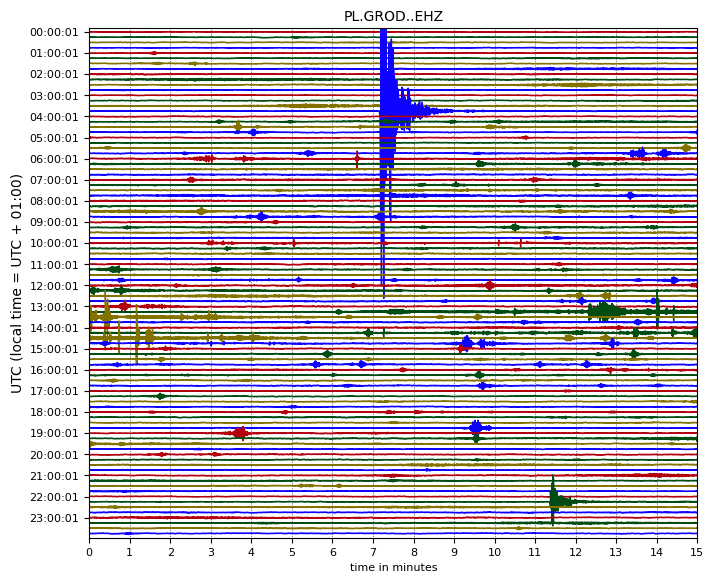

In [5]:
# sample of seismic signal in form of one day record from GROD station:

file = list_file[2]
record = ob.read(data_8_dir+file)
tr_reference = record[0]

fig = tr_reference.plot(type='dayplot')

In [6]:
tr_reference

PL.GROD..EHZ | 2016-03-08T00:00:01.170000Z - 2016-03-09T00:00:01.640000Z | 100.0 Hz, 8640048 samples

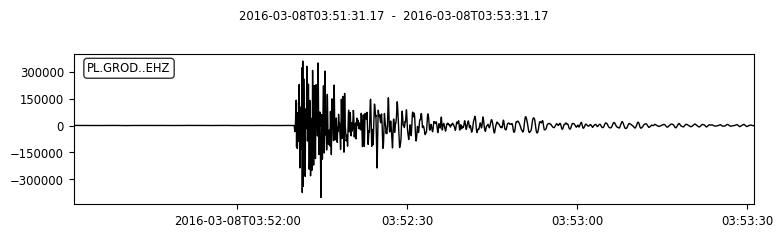

In [7]:
## -- plot of one induced earthquake recorded by GROD station -- ##

dt = tr_reference.stats.starttime
fig = tr_reference.plot(color='k', tck_format='%I:%M %p',
                   starttime=dt + 3*60*60+51.5*60, endtime=dt + 3*60*60+51.5*60 + 120)  # event registeret at 3:52:10

One day continuous record consist of ~8 000 000 samples. To limit this value, seismograms can be downsampled. In this case signals are downsampled to the samling rate 50 Hz:

In [44]:
traces = []
for i,file in enumerate(list_file[:-1]):
    record = ob.read(data_8_dir + file)
    traces.append(record[0].resample(50))
    print("\n----- trace " + file + " resampled!")
    
print('Traces =====> prepared')


----- trace PL.BRDW..EHZ.D.2016.068 resampled!

----- trace PL.DWOL..EHZ.D.2016.068 resampled!

----- trace PL.GROD..EHZ.D.2016.068 resampled!

----- trace PL.JEDR..EHZ.D.2016.068 resampled!

----- trace PL.KWLC..EHZ.D.2016.068 resampled!

----- trace PL.NWLU..EHZ.D.2016.068 resampled!

----- trace PL.RUDN..EHZ.D.2016.068 resampled!

----- trace PL.SGOR..EHZ.D.2016.068 resampled!

----- trace PL.TRN2..EHZ.D.2016.068 resampled!
Traces =====> prepared


Resampled records are stored in form of one-day Data Frame with P wave arrival classified as "1" and the rest of record classified ad "0". In this project P wave arrival is considered as the timestamp of P wave marker from .txt file plus the time window from 10 samples before to 14 samples after. With this approach we have 0.5 sec records assine as P wave arrival and considered as model pattern for classification.

In [45]:
## -- preparation of dataframe with stations records and assigned P wave picks -- ##

tr_reference = traces[0]

time = pd.date_range(tr_reference.stats.starttime.datetime, 
                      tr_reference.stats.endtime.datetime,
                      freq=str(tr_reference.stats.delta)+'S')
time = time.round('3ms')
df = pd.DataFrame(index=time)

for i,file in enumerate(list_file[:-1]):
    print("\n----- file " + file + " loaded!")
    current_station_picks = picks_P[picks_P.iloc[:,0] == file[3:-16]]
    
    tr = traces[i]
    
    station_time = pd.date_range(tr.stats.starttime.datetime, 
                          tr.stats.endtime.datetime, 
                          freq=str(tr.stats.delta)+'S')
    station_time = station_time.round('3ms')
    
    
    if (tr.stats.endtime.datetime > time[-1] - timedelta(hours=8)) and \
        not current_station_picks.empty:                     ## -- check if the daily record of current channel
        ## -- type of channel -- ##                           # has sufficient length and if the P wave has been marked on,
        if len(station_time) >= len(time):                    # if yes data are added to the dataframe -- ##
            if file[9:-11] == 'EHZ':
                station_df = pd.DataFrame({'EHZ_'+file[3:-16]:tr.data[:len(time)]}, 
                                          index=station_time[:len(time)])
            else:
                continue  
        else:
            lacks = len(time) - len(station_time)
            fill = np.zeros(lacks)
            if file[9:-11] == 'EHZ':
                station_df = pd.DataFrame({'EHZ_'+file[3:-16]:
                                           np.concatenate([tr.data,fill])}, 
                                           index=time)
            else:
                continue
        
        df = pd.merge_asof(df, station_df, 
                           left_on=df.index, 
                           right_on=station_df.index, 
                           direction="nearest")
        df = df.set_index('key_0')
   
    
        if file[9:-11] == 'EHZ' :
            df['picks_'+file[3:-16]] = 0                            ## -- assine P-wave markers to the seismic data -- ##
            for i, t in enumerate(current_station_picks['datetime']):
                p_index = df.index.get_loc(t, method='nearest')
                x_index = current_station_picks['datetime'].index[i]
                if current_station_picks['chanel'][x_index] == 'EHZ':
                    df['picks_'+file[3:-16]][p_index-10:p_index+15] = 25*[1.0]
                    print('P wave pick on', p_index)
                    print(df.loc[df.index[p_index]])
            
            print('data from station ' + file[3:-16] + ' - saved!')

    
    else:
        print('\nNOT ENOUGH DATA IN STATION ' + file[3:-16])
        pass

df.replace(np.nan, 0, inplace=True)


----- file PL.BRDW..EHZ.D.2016.068 loaded!


C:\Users\admin\anaconda3\envs\MLpy3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


P wave pick on 59862
EHZ_BRDW     -6244.18808
picks_BRDW       1.00000
Name: 2016-03-08 00:19:57.513000, dtype: float64
P wave pick on 696514
EHZ_BRDW      170.346
picks_BRDW      1.000
Name: 2016-03-08 03:52:10.554000, dtype: float64
P wave pick on 2140745
EHZ_BRDW     -34152.773278
picks_BRDW        1.000000
Name: 2016-03-08 11:53:35.172000, dtype: float64
P wave pick on 4038962
EHZ_BRDW     -5399.680121
picks_BRDW       1.000000
Name: 2016-03-08 22:26:19.512000, dtype: float64
data from station BRDW - saved!

----- file PL.DWOL..EHZ.D.2016.068 loaded!

NOT ENOUGH DATA IN STATION DWOL

----- file PL.GROD..EHZ.D.2016.068 loaded!
P wave pick on 59955
EHZ_BRDW     -217426.206500
picks_BRDW         0.000000
EHZ_GROD        -244.754138
picks_GROD         1.000000
Name: 2016-03-08 00:19:59.373000, dtype: float64
P wave pick on 696489
EHZ_BRDW      1756.222192
picks_BRDW       0.000000
EHZ_GROD       209.473825
picks_GROD       1.000000
Name: 2016-03-08 03:52:10.053000, dtype: float64
P wav

P wave pick on 59909
EHZ_BRDW      227678.916271
picks_BRDW         0.000000
EHZ_GROD        -126.553786
picks_GROD         0.000000
EHZ_JEDR       -1453.036839
picks_JEDR         1.000000
EHZ_KWLC         380.375489
picks_KWLC         0.000000
EHZ_RUDN         169.323679
picks_RUDN         0.000000
EHZ_SGOR         408.467253
picks_SGOR         0.000000
EHZ_TRN2       -4535.252131
picks_TRN2         1.000000
Name: 2016-03-08 00:19:58.452000, dtype: float64
P wave pick on 696454
EHZ_BRDW        5641.186562
picks_BRDW         0.000000
EHZ_GROD         -20.900111
picks_GROD         0.000000
EHZ_JEDR        -602.037484
picks_JEDR         0.000000
EHZ_KWLC         354.306815
picks_KWLC         0.000000
EHZ_RUDN         219.629583
picks_RUDN         0.000000
EHZ_SGOR        -853.636746
picks_SGOR         0.000000
EHZ_TRN2     -842022.375269
picks_TRN2         1.000000
Name: 2016-03-08 03:52:09.354000, dtype: float64
P wave pick on 839262
EHZ_BRDW      29347.534889
picks_BRDW        0.000000

In [48]:
## --  obtained dtatframe with vertical component of seismic records from each station -- ##
## -- + information of marked earthquakes in columns "picks_XXXX" -- ##

print(df.shape)
df.head(10)

(4320008, 14)


,EHZ_BRDW,picks_BRDW,EHZ_GROD,picks_GROD,EHZ_JEDR,picks_JEDR,EHZ_KWLC,picks_KWLC,EHZ_RUDN,picks_RUDN,EHZ_SGOR,picks_SGOR,EHZ_TRN2,picks_TRN2
key_0,,,,,,,,,,,,,,
2016-03-08 00:00:00.273,-1096.443656,0.0,315.689142,0.0,79.310929,0.0,-3288.426310,0.0,-172.606489,0.0,36.192954,0.0,-377.657400,0.0
2016-03-08 00:00:00.294,-983.054800,0.0,315.689142,0.0,156.687575,0.0,-379.838675,0.0,-172.606489,0.0,36.192954,0.0,-1169.955815,0.0
2016-03-08 00:00:00.312,-7955.874159,0.0,315.689142,0.0,305.502948,0.0,159.501645,0.0,-172.606489,0.0,36.192954,0.0,-1000.730526,0.0
2016-03-08 00:00:00.333,-6748.851527,0.0,315.689142,0.0,279.967848,0.0,1602.846785,0.0,-172.606489,0.0,36.192954,0.0,-1140.156616,0.0
2016-03-08 00:00:00.354,-3518.269931,0.0,315.689142,0.0,374.500251,0.0,1235.843163,0.0,-172.606489,0.0,36.192954,0.0,-959.135137,0.0
2016-03-08 00:00:00.372,-2034.182537,0.0,315.689142,0.0,417.572100,0.0,-637.604397,0.0,-172.606489,0.0,36.192954,0.0,-957.999713,0.0
2016-03-08 00:00:00.393,709.283094,0.0,315.689142,0.0,509.976977,0.0,-458.582290,0.0,-172.606489,0.0,36.192954,0.0,-1026.631618,0.0
2016-03-08 00:00:00.414,1636.545143,0.0,315.689142,0.0,642.942795,0.0,1422.912637,0.0,-172.606489,0.0,36.192954,0.0,-1212.609969,0.0
2016-03-08 00:00:00.432,3593.866276,0.0,315.689142,0.0,582.654985,0.0,1325.458617,0.0,-172.606489,0.0,36.192954,0.0,-1159.556135,0.0


To limit value of unnecessary noise, only part of the data were taken into further analysis. 30 seconds windows were cut randomly around the marked P waves from each channel.

In [49]:
##  --  Function for cat the time windows of seismic events, --  ##
##  --  function retuns new dataframe consist of cutted --  ##
##  --  events windows and the timestamps of the beggining --  ##
##  --  and the end of these windows --  ##

def random_window_cut(df, event_time_list, length=30):
    df_events = pd.DataFrame()
    time_window_len = {}
    stop = df.index[0]
    for i,ev_time in enumerate(event_time_list):
        p = random.choice(range(length))
        t = pd.Timestamp(ev_time)
        start = t - timedelta(seconds = p)
        if start > stop:
            stop = t + timedelta(seconds = length - p)
            df_ev = df.truncate(before = start,
                                after = stop)
            df_events = pd.concat([df_events, df_ev])
            # print(df_events[df_events['picks_JEDR']!=0.0])
            time_window_len['window_%d'%(i)] = [df_ev.index[0], df_ev.index[-1]]
        else:
            i = i-1
            ev_time = event_time_list[i]
            print('stop: %s ealier than stop: %s \n=> choosing new window' %(stop,start))
            pass
                    
    return df_events, time_window_len

In [50]:
df_events, time_windows = random_window_cut(df, ev_time)

In [52]:
## -- new data frame consist on 30 sec windows with recorded earthquake -- ##

print(df_events.shape)
df_events.head(10)

(10500, 14)


,EHZ_BRDW,picks_BRDW,EHZ_GROD,picks_GROD,EHZ_JEDR,picks_JEDR,EHZ_KWLC,picks_KWLC,EHZ_RUDN,picks_RUDN,EHZ_SGOR,picks_SGOR,EHZ_TRN2,picks_TRN2
key_0,,,,,,,,,,,,,,
2016-03-08 00:19:44.532,-3620.355946,0.0,-188.810015,0.0,142.319703,0.0,350.422829,0.0,188.959895,0.0,654.668129,0.0,438.436211,0.0
2016-03-08 00:19:44.553,-4400.545576,0.0,-235.190725,0.0,298.011727,0.0,10.688072,0.0,169.391880,0.0,536.649845,0.0,490.635989,0.0
2016-03-08 00:19:44.574,-1529.976408,0.0,-248.401101,0.0,325.272860,0.0,-178.675267,0.0,168.817439,0.0,458.534448,0.0,750.065708,0.0
2016-03-08 00:19:44.592,3248.827348,0.0,-208.965358,0.0,426.181595,0.0,62.772387,0.0,108.656385,0.0,281.233597,0.0,853.474943,0.0
2016-03-08 00:19:44.613,2558.292005,0.0,-204.344889,0.0,512.322949,0.0,74.322808,0.0,76.119644,0.0,321.216869,0.0,671.281488,0.0
2016-03-08 00:19:44.634,5638.895412,0.0,-236.718161,0.0,613.019344,0.0,-823.842518,0.0,43.147127,0.0,640.054452,0.0,463.898084,0.0
2016-03-08 00:19:44.652,7178.607994,0.0,-215.892959,0.0,601.679492,0.0,-1313.400304,0.0,51.118693,0.0,353.494498,0.0,467.197727,0.0
2016-03-08 00:19:44.673,5344.342624,0.0,-205.374648,0.0,510.916189,0.0,-599.385057,0.0,9.949178,0.0,-89.295176,0.0,390.321088,0.0
2016-03-08 00:19:44.694,-372.636348,0.0,-163.297684,0.0,577.012012,0.0,-459.377493,0.0,-37.543834,0.0,-44.733441,0.0,293.547926,0.0


In [53]:
## -- dictionary consist on timestamp of start and end of 30 sec windows -- ##

time_windows

{'window_0': [Timestamp('2016-03-08 00:19:44.532000'),
  Timestamp('2016-03-08 00:20:14.514000')],
 'window_1': [Timestamp('2016-03-08 03:51:58.434000'),
  Timestamp('2016-03-08 03:52:28.413000')],
 'window_2': [Timestamp('2016-03-08 04:39:23.292000'),
  Timestamp('2016-03-08 04:39:53.274000')],
 'window_3': [Timestamp('2016-03-08 04:52:38.373000'),
  Timestamp('2016-03-08 04:53:08.352000')],
 'window_4': [Timestamp('2016-03-08 06:24:22.632000'),
  Timestamp('2016-03-08 06:24:52.614000')],
 'window_5': [Timestamp('2016-03-08 11:53:17.514000'),
  Timestamp('2016-03-08 11:53:47.493000')],
 'window_6': [Timestamp('2016-03-08 22:26:00.693000'),
  Timestamp('2016-03-08 22:26:30.672000')]}

## High Order Statistics (HOS) Analysis

In order to highlight the P wave arrival on seismic records the HOS were calculated. Four features were extracted from vertical (EHZ) seismograms component:
- variance (Var), 
- absolute value of skewness (Skew), 
- kurtosis (Kurt),
- combination of skewness and kurtosis and of their derivatives respect to time we call IntegrInf (Integrated–Information “Integ” hereafter). 
and saved in one Dataframe together with the original seismic record.
They were calculated at each sample using a 2 sec long sliding window according the equations:

<img src="eq_HOS.png">

Data has been standardized before the integration.

HOS, as the preprocessing presented abowe, was calculated for all records and all days taken into analysis. 

In [54]:
## -- Function of High Order Statistics -- ##
## -- calculated on the basis of dataframe -- ##
## -- with cutted 30 sec events windows -- ##

def HOS(df_events, time_windows, calc_window=2):
    scaler = StandardScaler()
    df_base = df_events.copy()
    
    df_HOS = pd.DataFrame()
    columns = list(filter(lambda v: re.match('[A-Z]{3}_[*A-Z]', v), list(df_base.columns)))
    picks_P = list(filter(lambda v: re.match('picks_[*A-Z]', v), list(df_base.columns)))
    k = df_base.index.get_loc((df_base.index[0] + timedelta(seconds=calc_window)), method='nearest')
    
    for p,c in enumerate(columns):
        
        for key in list(time_windows.keys()):
            s_index = df_base.index.get_loc(time_windows[key][0])
            e_index = df_base.index.get_loc(time_windows[key][1])
            event_window_length = e_index - s_index
            print('\ncalculations for %s'%(key))
        
            col = df_base[c][s_index:e_index]
            pick_ev = df_base[picks_P[p]][s_index:e_index]
            df_hos = pd.DataFrame()
            
            ### --- HOS calculation for sliding window --- ###
            for i in range(event_window_length - k):
                temp_window = col[i:i+k]
                index_val = col.index[i+k]
                
                window_var = np.var(temp_window)
                df_hos.loc[index_val,'var'] = window_var
                
                window_skew = skew(temp_window)
                df_hos.loc[index_val,'skew'] = window_skew
                
                window_kurt = kurtosis(temp_window)
                df_hos.loc[index_val, 'kurt'] = window_kurt
            
            df_hos_scaled = scaler.fit_transform(df_hos)
            df_hos['var'] = df_hos_scaled[:,0]
            df_hos['skew'] = df_hos_scaled[:,1]
            df_hos['kurt'] = df_hos_scaled[:,2]

            dt = df_hos.index.to_series().diff().dt.total_seconds()
            dskew_dt = df_hos['skew'].diff().div(dt, axis=0)
            dkurt_dt = df_hos['kurt'].diff().div(dt, axis=0)
            window_integ = df_hos['skew' ] * df_hos['kurt'] * abs(dskew_dt*dkurt_dt)
            df_hos['integ'] = window_integ
            
            print('HOS and Integral for channel %s saved'%(c))
            
            df_ev = pd.merge(col.to_frame(name='raw_data'), df_hos, how='left',
                               left_on = col.index, right_on = df_hos.index)
            df_ev = df_ev.set_index('key_0')
            df_full = pd.merge(df_ev, pick_ev.to_frame(name='picks_P'), how='left',
                               left_on = df_ev.index, right_on = pick_ev.index)

            df_HOS = pd.concat([df_HOS, df_full])
    
    df_HOS.replace(np.nan, 0, inplace=True)
    
    return df_HOS

In [55]:
df_HOS = HOS(df_events, time_windows)

f = open(date + '_HOS.pckl', 'wb')
pickle.dump(df_HOS, f)
f.close()


calculations for window_0
HOS and Integral for channel EHZ_BRDW saved

calculations for window_1
HOS and Integral for channel EHZ_BRDW saved

calculations for window_2
HOS and Integral for channel EHZ_BRDW saved

calculations for window_3
HOS and Integral for channel EHZ_BRDW saved

calculations for window_4
HOS and Integral for channel EHZ_BRDW saved

calculations for window_5
HOS and Integral for channel EHZ_BRDW saved

calculations for window_6
HOS and Integral for channel EHZ_BRDW saved

calculations for window_0
HOS and Integral for channel EHZ_GROD saved

calculations for window_1
HOS and Integral for channel EHZ_GROD saved

calculations for window_2
HOS and Integral for channel EHZ_GROD saved

calculations for window_3
HOS and Integral for channel EHZ_GROD saved

calculations for window_4
HOS and Integral for channel EHZ_GROD saved

calculations for window_5
HOS and Integral for channel EHZ_GROD saved

calculations for window_6
HOS and Integral for channel EHZ_GROD saved

calcu

In [68]:
print(df_HOS.shape)
df_HOS.iloc[630:650,:]

(73451, 7)


,key_0,raw_data,var,skew,kurt,integ,picks_P
630,2016-03-08 00:19:57.132,-18402.886874,-0.327210,-0.308238,-0.131933,0.096337,0.0
631,2016-03-08 00:19:57.153,6647.229425,-0.327174,-0.320904,-0.158084,0.038103,0.0
632,2016-03-08 00:19:57.174,3063.992803,-0.327171,-0.372526,-0.160131,0.014295,0.0
633,2016-03-08 00:19:57.192,13194.386320,-0.327170,-0.401514,-0.159564,0.003248,0.0
634,2016-03-08 00:19:57.213,-13215.021799,-0.327159,-0.384152,-0.167982,0.021386,0.0
635,2016-03-08 00:19:57.234,-1291.041300,-0.327147,-0.312331,-0.182976,0.139550,0.0
636,2016-03-08 00:19:57.252,-14521.101300,-0.327177,-0.333413,-0.165553,0.062578,0.0
637,2016-03-08 00:19:57.273,8166.314628,-0.327159,-0.271049,-0.184578,0.134607,0.0
638,2016-03-08 00:19:57.294,-9393.669842,-0.327153,-0.329536,-0.188460,0.031973,0.0
639,2016-03-08 00:19:57.312,8991.527839,-0.327146,-0.311020,-0.197400,0.031366,1.0


In [90]:
dfh = df_HOS.set_index('key_0')

## -- index of first earthquake P wave arrival -- ##
idxP = dfh[0:2998].index.get_loc(ev_t.iloc[0], method='nearest')
idxP

649

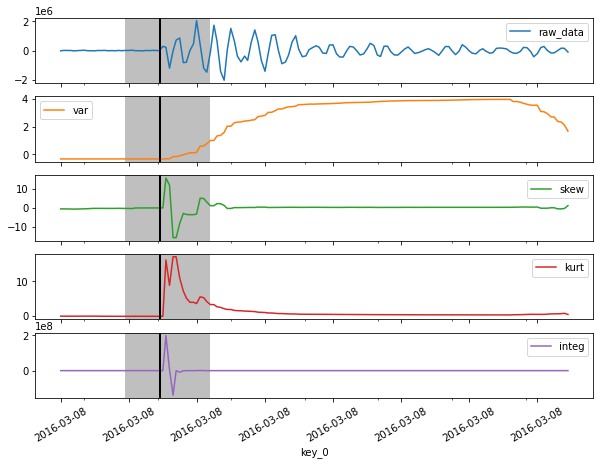

In [322]:
## -- sample plot of one earthquake record from one station (BRDW) with its HOS attributes -- ##
## -- black bold line is a P wave arrival marker -- ##
## -- grey area is a window of 25 samples taken to analysis  -- ##
## -- as a reference signal of P wave arrival (classified as "1") -- ## 

plot_cols = list(df_HOS.columns)[1:-1]

fig, axes = plt.subplots(5,1, figsize=(10,7), sharex=True)
dfh[plot_cols][620:770].plot(subplots=True, ax=axes, xticks=dfh.index[620:770:20],rot=30, legend=True)
for ax in axes:
    ax.axvline(ev_t.iloc[0], 
                color='k', linestyle='-', linewidth=2)
    ax.axvspan(list(df_HOS['key_0'][idxP-10])[0], list(df_HOS['key_0'][idxP+15])[0], facecolor='grey', alpha = 0.5)


In order to apply CNN the data should be prepared in form of an **numpy array**. Function TimeSeries2matrix transform dataset from vertical Dataframe with 30 sec windows of each seismic event into the data matrix (X set) and to the classification array (y set). Each 30 sec event window has been cutted into 0.5 sec time series (25 samples) with 5 channels (original seismic data, var, skew, kurt and integ) thus data matrix has shape (N, 25, 5) where N is dependent on different number of seismic events recorded on the analized date.

In [108]:
## -- Function to data transformation: dataframe to numpy array (N,25,5) -- ##

def TimeSeries2matrix(df_HOS):
    new_df = df_HOS.copy()
    
    new_df = new_df.drop(columns=['key_0'], axis=1)
    new_df = new_df.T
    full_array = new_df.to_numpy()
    
    M = np.zeros((1,25,6))
    for window in range(0, full_array.shape[1], 1500):
        array = full_array[:,window:window+1500]
        first_P = list(np.where(array[-1,:]==1)[0])
        
        if len(first_P)==0:
            continue
        elif first_P[0]%25!=0:
            zero_size_before = np.zeros((6,25-first_P[0]%25))
            array = np.hstack((zero_size_before, array))
            zero_size_after = np.zeros((6,25-array.shape[1]%25))
            array = np.hstack((array, zero_size_after))
            array = array[:,25:-25]
            matrix = array.reshape(6,int(array.shape[1]/25),25).swapaxes(1,2)
            matrix = matrix.T

        else:
            matrix = array.reshape(6,int(array.shape[1]/25),25).swapaxes(1,2)
            matrix = matrix.T
        
        M =  np.vstack((M, matrix))
    print('Time Series matrix created!')
    
    X = M[1::,:,0:5]
    y = M[1::,-1,-1]
    
    return X, y

In [109]:
X, y = TimeSeries2matrix(df_HOS)

## -- After pre-processing, HOS calculations and transformation to array form -- ##
## -- data are save and stored in pickle files: -- ##

f = open(date+'_X_y.pckl', 'wb')
pickle.dump([X,y], f)
f.close()

Time Series matrix created!


In [112]:
X.shape

(2183, 25, 5)

In [113]:
y.shape

(2183,)

#### Training and Test datasets

All data for 18 days dataset were prepared according the scheme above (Sections "Data preprocessing" and "HOS Analysis") and stored in pickle files.

Since seismic events are random phenomenas and the their 30 sec time windows were also chosen randomly there is no need to split data set using random selection method (for exemple wiyh scikit-learn's *train_test_split()*). In the project the training set consist of 15 days of analysis (8th - 22nd of March 2016) and the test set contain data from last 3 days (23rd - 25th of March 2016).

In [8]:
data_file_list = [f for f in os.listdir('..') if f.endswith('_X_y.pckl')]
data_file_list

['08_03_2016_X_y.pckl',
 '09_03_2016_X_y.pckl',
 '10_03_2016_X_y.pckl',
 '11_03_2016_X_y.pckl',
 '12_03_2016_X_y.pckl',
 '13_03_2016_X_y.pckl',
 '14_03_2016_X_y.pckl',
 '15_03_2016_X_y.pckl',
 '16_03_2016_X_y.pckl',
 '17_03_2016_X_y.pckl',
 '18_03_2016_X_y.pckl',
 '19_03_2016_X_y.pckl',
 '20_03_2016_X_y.pckl',
 '21_03_2016_X_y.pckl',
 '22_03_2016_X_y.pckl',
 '23_03_2016_X_y.pckl',
 '24_03_2016_X_y.pckl',
 '25_03_2016_X_y.pckl']

In [9]:
## -- creation of full train dataset from data saved in .pckl files -- ##

X_train = np.empty((1,25,5), float)
y_train = np.empty((1,), float)

for file in data_file_list[:-3]:
    with open(data_dir+'\\'+file, 'rb') as d:
        data1 = pickle.load(d)
        X_train =  np.concatenate((X_train, data1[0]), axis=0)
        y_train =  np.concatenate((y_train, data1[1]), axis=0)
        print('{} X length: {}'.format(file[:-9], data1[0].shape[0]))
    d.close()

08_03_2016 X length: 2183
09_03_2016 X length: 1063
10_03_2016 X length: 1063
11_03_2016 X length: 650
12_03_2016 X length: 1888
13_03_2016 X length: 1298
14_03_2016 X length: 1773
15_03_2016 X length: 532
16_03_2016 X length: 827
17_03_2016 X length: 295
18_03_2016 X length: 711
19_03_2016 X length: 1301
20_03_2016 X length: 178
21_03_2016 X length: 412
22_03_2016 X length: 295


In [10]:
print('X_train shape:', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape: (14470, 25, 5)
y_train shape:  (14470,)


In [11]:
## -- creation of full test dataset from data saved in .pckl files -- ##

X_test = np.empty((1,25,5), float)
y_test = np.empty((1,), float)

for file in data_file_list[-3:]:
    with open(data_dir+'\\'+file, 'rb') as d:
        data1 = pickle.load(d)
        X_test =  np.concatenate((X_test, data1[0]), axis=0)
        y_test =  np.concatenate((y_test, data1[1]), axis=0)
        print('{} X length: {}'.format(file[:-9], data1[0].shape[0]))
    d.close()

23_03_2016 X length: 648
24_03_2016 X length: 296
25_03_2016 X length: 767


In [12]:
print('X_test shape:', X_test.shape)
print('y_test shape: ', y_test.shape)

X_test shape: (1712, 25, 5)
y_test shape:  (1712,)


Unfortunately despite the cutting out parts of seismic signals, the dataset is strongly imbalanced. To reduce this state, **the random oversampling and undersampling** is needed.

Class 0: 14227
Class 1: 242
Proportion: 58.79 : 1


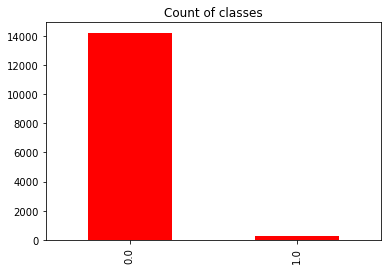

In [13]:
## -- plot representing the data classification balance -- ##

dfy_train = pd.Series(y_train[1:])
class_count = dfy_train.value_counts()
print('Class 0:', class_count[0])
print('Class 1:', class_count[1])
print('Proportion:', round(class_count[0] / class_count[1], 2), ': 1')

class_count.plot(kind='bar', title='Count of classes', color='r');

Data for oversampling need to be in the form of 2D array, not a 3D matrix, thus the train dataset need to be flatten.

In [14]:
len_samples, num_hos = X_train.shape[1], X_train.shape[2]

input_shape = (len_samples*num_hos)
X_train_c = X_train.reshape(X_train.shape[0], input_shape)
X_train_c = X_train_c[1:,]
y_train_c = y_train[1:,]

X_test_c = X_test.reshape(X_test.shape[0], input_shape)
X_test_c = X_test_c[1:,]
y_test_c = y_test[1:,]

print('X_train shape:', X_train_c.shape)
print('input_shape:', input_shape)
print('y_train shape:', y_train_c.shape)

print('\nX_test shape:', X_test_c.shape)
print('y_test shape:', y_test_c.shape)

X_train shape: (14469, 125)
input_shape: 125
y_train shape: (14469,)

X_test shape: (1711, 125)
y_test shape: (1711,)


In [15]:
## -- data oversampling -- ##

ros = RandomOverSampler(sampling_strategy=0.3, random_state=42)

X_ros, y_ros = ros.fit_resample(X_train_c, y_train_c)

In [16]:
y_ros[y_ros==1.0].sum()

4268.0

Class 0: 14227
Class 1: 4268
Proportion: 3.33 : 1


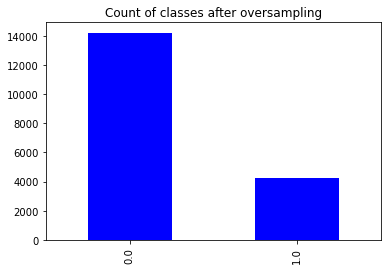

In [17]:
## -- plot representing the data classification balance after the oversampling procedure -- ##

dfy_ros = pd.Series(y_ros)
class_count = dfy_ros.value_counts()
print('Class 0:', class_count[0])
print('Class 1:', class_count[1])
print('Proportion:', round(class_count[0] / class_count[1], 2), ': 1')

class_count.plot(kind='bar', title='Count of classes after oversampling', color='b');

In [18]:
## -- data undersampling -- ##

rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

X_rus, y_rus = rus.fit_resample(X_ros, y_ros)

Class 0: 6097
Class 1: 4268
Proportion: 1.43 : 1


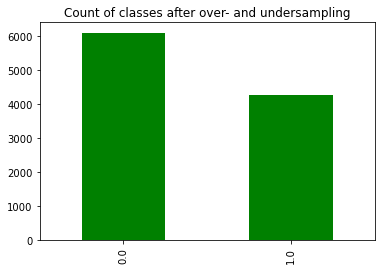

In [19]:
## -- plot representing the data classification balance after the undersampling procedure -- ##

dfy_rus = pd.Series(y_rus)
class_count = dfy_rus.value_counts()
print('Class 0:', class_count[0])
print('Class 1:', class_count[1])
print('Proportion:', round(class_count[0] / class_count[1], 2), ': 1')

class_count.plot(kind='bar', title='Count of classes after over- and undersampling', color='g');

## CNN Model

In [43]:
batch_size = 25
epochs = 20
len_samples = X_train.shape[1] 
num_hos = X_train.shape[2]
input_shape = X_ros.shape[1]

model = Sequential()

model.add(Reshape((len_samples, num_hos), input_shape=(input_shape,)))

model.add(Conv1D(filters=100, kernel_size=5, activation='relu', input_shape=(len_samples, num_hos)))

model.add(Conv1D(100, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same', data_format='channels_last'))

model.add(Conv1D(50, 5, activation='relu'))
model.add(Conv1D(50, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same', data_format='channels_last'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))

model.add(Dense(1, activation='tanh'))
# model.add(Dense(1))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 25, 5)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 21, 100)           2600      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 17, 100)           50100     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 9, 100)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 5, 50)             25050     
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 1, 50)             12550     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1, 50)            

In [44]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="accuracy", 
                                patience=5, 
                                restore_best_weights=True)
check_hist = ModelCheckpoint(filepath='best_model.{epoch:02d}-{accuracy:.2f}.h5',
                                monitor='accuracy', save_best_only=True)

mod_fit = model.fit(X_rus, y_rus, 
                    validation_split=0.1,
                    epochs=epochs, 
                    batch_size=batch_size , 
                    callbacks=[early_stopping, check_hist])

Epoch 1/20
374/374 [==============================] - 2s 5ms/step - loss: 2.2732 - accuracy: 0.5602 - val_loss: 0.5669 - val_accuracy: 0.8573
Epoch 2/20
374/374 [==============================] - 2s 5ms/step - loss: 1.1367 - accuracy: 0.5244 - val_loss: 0.9444 - val_accuracy: 0.0550
Epoch 3/20
374/374 [==============================] - 2s 5ms/step - loss: 0.7518 - accuracy: 0.5552 - val_loss: 0.9678 - val_accuracy: 0.0087
Epoch 4/20
374/374 [==============================] - 2s 5ms/step - loss: 0.7144 - accuracy: 0.6181 - val_loss: 1.1206 - val_accuracy: 0.0068
Epoch 5/20
374/374 [==============================] - 2s 5ms/step - loss: 0.6921 - accuracy: 0.6070 - val_loss: 0.7446 - val_accuracy: 0.3385
Epoch 6/20
374/374 [==============================] - 2s 5ms/step - loss: 0.6574 - accuracy: 0.6471 - val_loss: 0.8952 - val_accuracy: 0.0000e+00
Epoch 7/20
374/374 [==============================] - 2s 5ms/step - loss: 0.7447 - accuracy: 0.6004 - val_loss: 0.6403 - val_accuracy: 0.8698
Ep

In [45]:
_, accuracy = model.evaluate(X_test_c, y_test_c, batch_size=batch_size, verbose=0)

In [46]:
accuracy

0.9713617563247681

In [221]:
np.where(y_test_c==1)

(array([  25,   72,  146,  214,  261,  335,  366,  440,  508,  555,  602,
         663,  724,  782,  841,  901, 1000, 1033, 1085, 1173, 1212, 1296,
        1327, 1388, 1439, 1504, 1588, 1622, 1673], dtype=int64),)

In [51]:
y_pred_train = model.predict(X_rus)

# The class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_rus, max_y_pred_train))

              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74      6097
         1.0       0.00      0.00      0.00      4268

    accuracy                           0.59     10365
   macro avg       0.29      0.50      0.37     10365
weighted avg       0.35      0.59      0.44     10365



C:\Users\admin\anaconda3\envs\MLpy3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\envs\MLpy3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\envs\MLpy3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
y_pred_test = model.predict(X_test_c)

# The class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_test, axis=1)
print(classification_report(y_test_c, max_y_pred_train))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1682
         1.0       0.00      0.00      0.00        29

    accuracy                           0.98      1711
   macro avg       0.49      0.50      0.50      1711
weighted avg       0.97      0.98      0.97      1711



C:\Users\admin\anaconda3\envs\MLpy3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\envs\MLpy3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\envs\MLpy3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


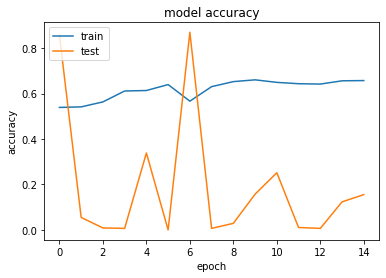

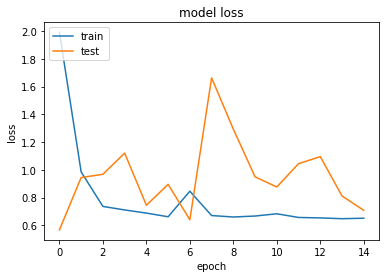

In [54]:
# list all data in history
print(mod_fit.history.keys())
# summarize history for accuracy
plt.plot(mod_fit.history['accuracy'])
plt.plot(mod_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mod_fit.history['loss'])
plt.plot(mod_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Summary

The seismic records are challenging data. Their quality depends on various elements starting from sensor type and settings, station location, background noise, earthquake type, its strength and source-station distance, ending on skills of P and S waves marking person. These factors and further pre-processing of the data can influence on prepared CNN model accuracy. In case of presented project the convolutional neural network couldn't reach satisfying level of record classification prediction. The waveform filtration using bandpass filter and completion of dataset by bigger number of earthquakes, could be helpful in future algorithm development.

#### *Bibliography*

***Scientific papers:***
- Allen R.V., (1978), *Automatic earthquake recognition and timing from single trace*, Bulletin of the Seismological Society of America, 68, pp. 1521–1532.
- **Chen Y., Zhang G., Bai M., Zu S., Guan Z., Zhang M., (2019), *Automatic waveform classification and arrival picking based on convolutional neural network.* Earth and Space Science, 6, pp.1244– 1261, doi.org/10.1029/2018EA000466.
- **Gentili S., Michelini A., (2006), *Automatic picking of P and S phases using a neural tree*, Journal of Seismology, 10, pp. 39–63, DOI: 10.1007/s10950-006-2296-6**.
- **Kuperkoch L., Meier T., Lee J., Friederich W., EGELADOS Working Group, (2010), *Automated determination of P-phase arrival times at regionaland local distances using higher order statistics*, Geophysical Journal International, 181, pp.1159–1170, doi: 10.1111/j.1365-246X.2010.04570.x.**
- Leonard M., Kennett B.L.N., (1999), *Multi component autoregressive techniques for the analysis of seismograms*, Physics of the Earth and Planetary Interiors, 113(2), pp.247–264.
- Leonard, M., (2000), *Comparison of Manual and Automatic Onset Time Picking*, Bulletin of the Seismological Society of America, 90(6), pp.1384–1390.
- **Ross Z. E., Meier M.‐A., Hauksson E., (2018), *P wave arrival picking and first‐motion polarity determination with deep learning,* Journal of Geophysical Research: Solid Earth, 123, pp.5120– 5129. doi.org/10.1029/2017JB015251.**
- Wang J., Teng T.L., (1995), *Artificial Neural Network-Based Seismic Detector*, Bulletin of the Seismological Society of America, 85(1), pp.308–319.
- Zhang H., Thurber C. and Rowe C., (2003), *Automatic P-wave Arrival Detection and Picking with MultiscaleWavelet Analysis for Single-Component Recording*, Bulletin of the Seismological Society of America, 93(5), pp.1904–1912.

***On-line publications:***
- *Human Activity Recognition (HAR) Tutorial with Keras and Core ML (Part 1)* (https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0).
- *Introduction to 1D Convolutional Neural Networks in Keras for Time Sequences* (https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf).
- *How to Develop Convolutional Neural Network Models for Time Series Forecasting* (https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/).